In [156]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.io import read_image
import json 
import copy

from tools import *

data_p = Path('data/data.json')
with open(data_p, 'r') as f:
    data = json.load(f)


image dim: torch.Size([3, 59, 218])


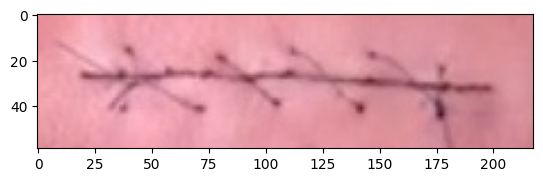

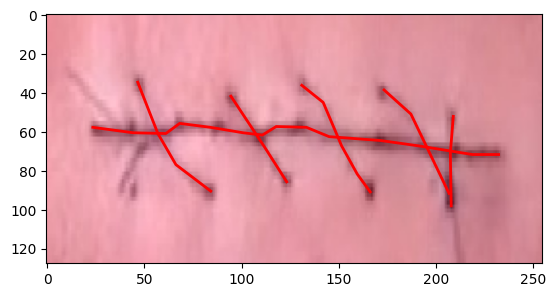

In [181]:
# torch interpolate
image_id = 121
SIZE = (128,255)

annot = data[str(image_id)]
image_p = Path('data/images/default')/annot['file']

im = read_image(str(image_p))
inter_coeff = (SIZE[0]/im.shape[1], SIZE[1]/im.shape[2])  # the interpolation ratio

plt.imshow(im.permute(1, 2, 0))
print(f"image dim: {im.shape}")

im = im.unsqueeze(0)
im2 = F.interpolate(im, size=SIZE) # size=(3,128,255)


im_toshow = im2[0].permute(1, 2, 0) 
fig, ax = plt.subplots()
ax.imshow(im_toshow)


# interpolate the annotation
for idx, label in enumerate(data[str(image_id)]['label']):
    points = data[str(image_id)]['points'][idx]
    x_coords, y_coords = zip(*points)
    x_coords = np.array(x_coords, dtype=float) * inter_coeff[1]
    y_coords = np.array(y_coords, dtype=float) * inter_coeff[0]
    ax.plot(x_coords, y_coords, color='red', linewidth=2)
plt.show()

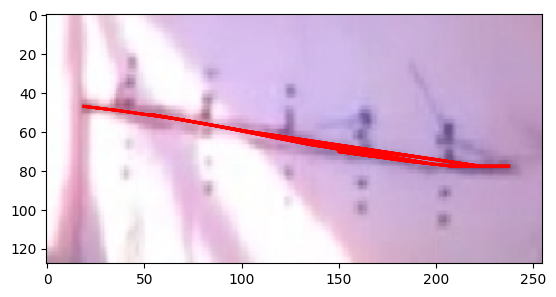

In [116]:
# data to fixed amount of segments --> interpolation
# *16 for incision
# *2 for a stitch
im_toshow = im2[0].permute(1, 2, 0) 
fig, ax = plt.subplots()
ax.imshow(im_toshow)
# for image_id in data:
for idx, label in enumerate(data[str(image_id)]['label']):
    #points = data[str(image_id)]['points'][idx]
    x_coords, y_coords = zip(*points)
    x_coords = np.array(x_coords, dtype=float) * inter_coeff[1]
    y_coords = np.array(y_coords, dtype=float) * inter_coeff[0]
    ax.plot(x_coords, y_coords, color='red', linewidth=2)
    # for i in range(len(x_coords)):
    #     plt.plot(x_coords[i], y_coords[i],'xr')




incision points: 15


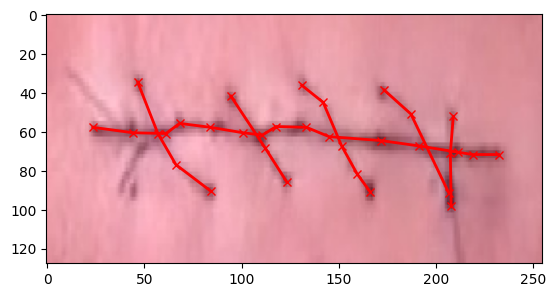

In [182]:
# add segment 
POINT_COUNT = 16 # target point count

incision_idx = data[str(image_id)]['label'].index('Incision')
points = np.array(data[str(image_id)]['points'][incision_idx], dtype=float)
print(f"incision points: {len(points)}")


im_toshow = im2[0].permute(1, 2, 0) 
fig, ax = plt.subplots()
ax.imshow(im_toshow)
# for image_id in data:
for idx, label in enumerate(data[str(image_id)]['label']):
    pts = data[str(image_id)]['points'][idx]
    x_coords, y_coords = zip(*pts)
    x_coords = np.array(x_coords, dtype=float) * inter_coeff[1]
    y_coords = np.array(y_coords, dtype=float) * inter_coeff[0]
    ax.plot(x_coords, y_coords, color='red', linewidth=2)
    for i in range(len(x_coords)):
        plt.plot(x_coords[i], y_coords[i],'xr')

while True:
    gaps = [0] * (len(points)-1)
    midpoints = [0] * (len(points)-1)
    for i, p in enumerate(points):
        if i < len(points)-1:
            gaps[i] = np.sqrt((p[0] - points[i+1][0])**2 + (p[1] - points[i+1][1])**2)
            midpoints[i] = np.array([p[0] + points[i+1][0], p[1] + points[i+1][1]]) / 2  
    gap_idxs = np.flip(np.argsort(gaps)) # gap size by magnitude

    # add new point in the middle 
    new_points = list(copy.deepcopy(points))
    new_points_count = np.min([len(points)-1, POINT_COUNT - len(points)]) 
    for i in range(new_points_count):
        gidx = gap_idxs[i]
        offset = np.sum(gap_idxs[:i] <= gidx) # already inserted before target index
        new_points.insert(gidx+1+offset, midpoints[gidx])
    
    points = new_points
    if len(points) >= POINT_COUNT: 
        break
    

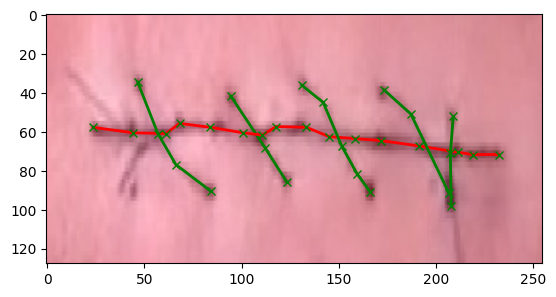

In [183]:
im_toshow = im2[0].permute(1, 2, 0) 
fig, ax = plt.subplots()
ax.imshow(im_toshow)

color = {
        'Incision': 'r',
        'Stitch': 'g'
    }

# for image_id in data:
for idx, label in enumerate(data[str(image_id)]['label']):
    pts = data[str(image_id)]['points'][idx]
    if data[str(image_id)]['label'][idx] == 'Incision':
        pts = points
    x_coords, y_coords = zip(*pts)
    x_coords = np.array(x_coords, dtype=float) * inter_coeff[1]
    y_coords = np.array(y_coords, dtype=float) * inter_coeff[0]
    ax.plot(x_coords, y_coords, color=color[label], linewidth=2)
    for i in range(len(x_coords)):
        plt.plot(x_coords[i], y_coords[i],'xg')

In [177]:
offset

3